In [1]:
%run ../../bin/imports.ipynb
from xgboost import XGBClassifier

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Fully clonal mixtures

In [27]:
cell_lines = ['CRL-5911', 'CRL-2314', 'CRL-5922']
cell_line = cell_lines[0]

In [28]:
cutoff = 0.5
BAF_cutoff = 0.02
R_cutoff = 0.98

In [29]:
training_columns = ['purity', 'ploidy', 'Sequenza_Loss',
                    'minMedCoverage','baf_median', 'percCov', 'totalCoverage_median']

output_ffn = '/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/training.xgboost_model.2021_05_10.p'
model = pickle.load(open(output_ffn, 'rb'))

##### Sensitivity with fully clonal mixtures

In [30]:
artificial_purities_raw_df = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/validation.cell_line_dash_output.{0}.csv'.format(cell_line),
                                     index_col=0)
artificial_purities_raw_df['LOH'] = True
artificial_purities_raw_df['real_purity'] = artificial_purities_raw_df['Sample'].str.split('_p').str[1].str.split('_').str[0].astype(int)
artificial_purities_raw_df['Dash_Loss_Prob'] = artificial_purities_raw_df['prediction_probability']
#artificial_purities_raw_df['Dash_Loss_Ext'] = artificial_purities_raw_df.prediction_probability <= cutoff

# Adding in another check
artificial_purities_raw_df['R_min'] = artificial_purities_raw_df[['R1', 'R2']].min(axis=1)
artificial_purities_raw_df['Check_FP'] = (artificial_purities_raw_df.BAF > BAF_cutoff) \
                                         &(artificial_purities_raw_df.R_min < R_cutoff) #\
                                         #&(artificial_purities_raw_df.Sequenza_Loss == False)

artificial_purities_raw_df['Dash_Loss_Ext'] = (artificial_purities_raw_df.prediction_probability > cutoff) \
                                                &(artificial_purities_raw_df.Check_FP)


In [31]:
artificial_purities_raw_df.head()

,Purity,R1,R2,BAF,Sequenza_Loss,Alternate_Loss,Dash_Loss,Ploidy,consistency_of_coverage,prediction_probability,...,total_coverage,Gene,Sample,ind,LOH,real_purity,Dash_Loss_Prob,R_min,Check_FP,Dash_Loss_Ext
0,1.00,1.592688,0.000070,0.477152,True,True,True,5,0.913043,0.996421,...,1.592779,B,DNA_VVV_S15_P10_9_tumor_p100_rep4,0,True,100,0.996421,0.000070,True,True
1,1.00,0.000057,1.534270,0.475643,True,True,True,5,0.956522,0.996365,...,1.534338,C,DNA_VVV_S15_P10_9_tumor_p100_rep4,1,True,100,0.996365,0.000057,True,True
2,0.15,1.213152,0.728154,0.117403,True,False,True,5,0.913043,0.992545,...,1.958221,B,DNA_VVV_S15_P10_9_tumor_p28_rep2,2,True,28,0.992545,0.728154,True,True
3,0.15,1.142597,0.743451,0.109564,True,True,True,5,0.956522,0.992596,...,1.852432,C,DNA_VVV_S15_P10_9_tumor_p28_rep2,3,True,28,0.992596,0.743451,True,True
4,0.10,1.061544,0.893231,0.045824,True,True,True,3,0.869565,0.951362,...,1.965687,B,DNA_VVV_S15_P10_9_tumor_p10_rep10,4,True,10,0.951362,0.893231,True,True


In [32]:
artificial_purities_raw_df.groupby('real_purity').Dash_Loss_Ext.mean()

real_purity
0      0.00
2      0.25
3      0.25
4      0.30
5      0.50
6      0.60
7      0.80
8      0.95
9      1.00
10     1.00
12     1.00
14     1.00
15     1.00
16     1.00
18     1.00
20     1.00
21     1.00
24     1.00
25     1.00
27     1.00
28     1.00
30     1.00
32     1.00
35     1.00
36     1.00
40     1.00
42     1.00
45     1.00
48     1.00
49     1.00
50     1.00
54     1.00
56     1.00
60     1.00
63     1.00
64     1.00
70     1.00
72     1.00
80     1.00
81     1.00
90     1.00
100    1.00
Name: Dash_Loss_Ext, dtype: float64

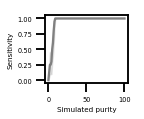

In [33]:
plt.figure(figsize=(1.5, 1.25))
sns.set_context('talk', font_scale=0.4)

sns.lineplot(x='real_purity', y='Dash_Loss_Ext', data=artificial_purities_raw_df, color='grey')

plt.xlabel('Simulated purity')
plt.ylabel('Sensitivity')
#plt.title('DASH')
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/DASH.sensitivity.purity.line.{0}.pdf'.format(cell_line),
            bbox_inches='tight')

##### Sensitivity across variable clonalities

In [34]:
# Make new column: adjusted purity (to reflect subclonality)
all_small_artificial_dfs = []
purities = list(range(10, 110, 10))
clonalities = list(range(10, 110, 10))
for purity in purities:
    for clonality in clonalities:
        actual_purity = round(int(purity*clonality)/100)
        tmp_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == actual_purity]
        # Need to actually adjust this to the purity that would be called by sequenza!
        sequenza_purity = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Purity.mean()
        tmp_df['adjusted_purity'] = sequenza_purity
        # Trying ploidy
        sequenza_ploidy = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Ploidy.mean()
        tmp_df['adjusted_ploidy'] = sequenza_ploidy
        all_small_artificial_dfs.append(tmp_df)
        print(purity, clonality, actual_purity, sequenza_purity)

artificial_purities_df = pd.concat(all_small_artificial_dfs)

artificial_purities_df['old_purity'] = artificial_purities_df['Purity']
# This line adjusts the purity input to the model based on clonality
artificial_purities_df['purity'] = artificial_purities_df['adjusted_purity']
artificial_purities_df['ploidy'] = artificial_purities_df['adjusted_ploidy']

#artificial_purities_df['ploidy'] = artificial_purities_df['Ploidy']
artificial_purities_df['sequenza_minor'] = [0 if x == True else 1 for x in artificial_purities_df['Sequenza_Loss']]
artificial_purities_df['minMedCoverage'] = artificial_purities_df[['R1','R2']].min(axis=1)
artificial_purities_df['baf_median'] = artificial_purities_df['BAF']
artificial_purities_df['percCov'] = artificial_purities_df['consistency_of_coverage']
artificial_purities_df['totalCoverage_median'] = artificial_purities_df['total_coverage']
artificial_purities_df['Sequenza_Loss'] = ~artificial_purities_df['sequenza_minor'].astype(bool)

10 10 1 0.10500000000000001
10 20 2 0.10500000000000001
10 30 3 0.10500000000000001
10 40 4 0.10500000000000001
10 50 5 0.10500000000000001
10 60 6 0.10500000000000001
10 70 7 0.10500000000000001
10 80 8 0.10500000000000001
10 90 9 0.10500000000000001
10 100 10 0.10500000000000001
20 10 2 0.11000000000000001
20 20 4 0.11000000000000001
20 30 6 0.11000000000000001
20 40 8 0.11000000000000001
20 50 10 0.11000000000000001
20 60 12 0.11000000000000001
20 70 14 0.11000000000000001
20 80 16 0.11000000000000001
20 90 18 0.11000000000000001
20 100 20 0.11000000000000001
30 10 3 0.16000000000000003
30 20 6 0.16000000000000003
30 30 9 0.16000000000000003
30 40 12 0.16000000000000003
30 50 15 0.16000000000000003
30 60 18 0.16000000000000003
30 70 21 0.16000000000000003
30 80 24 0.16000000000000003
30 90 27 0.16000000000000003
30 100 30 0.16000000000000003
40 10 4 0.223
40 20 8 0.223
40 30 12 0.223
40 40 16 0.223
40 50 20 0.223
40 60 24 0.223
40 70 28 0.223
40 80 32 0.223
40 90 36 0.223
40 100 40 

In [35]:
X_test = artificial_purities_df[training_columns]
y_test = artificial_purities_df[['LOH']]

predictions = model.predict(X_test)
prediction_probs = model.predict_proba(X_test)[:, 1]

In [36]:
# Adding second check
artificial_purities_df['Check_FP'] = (artificial_purities_df.baf_median > BAF_cutoff) \
                                         &(artificial_purities_df.minMedCoverage < R_cutoff) #\

artificial_purities_df['Dash_Loss_Ext'] = (artificial_purities_df.prediction_probability > cutoff) \
                                                &(artificial_purities_df.Check_FP)


In [37]:
# Lenient
lenient = []
for x, check in zip(prediction_probs, artificial_purities_df['Check_FP']):
    if (x > cutoff) and check:
        lenient.append(1)
    else:
        lenient.append(0)
artificial_purities_df['Dash_Loss_Ext'] = lenient

In [38]:
artificial_purities_df.groupby('real_purity').Dash_Loss_Ext.mean()

real_purity
2      0.000000
3      0.000000
4      0.133333
5      0.175000
6      0.350000
7      0.350000
8      0.512500
9      0.683333
10     0.787500
12     0.937500
14     0.975000
15     0.975000
16     1.000000
18     1.000000
20     1.000000
21     1.000000
24     1.000000
25     1.000000
27     1.000000
28     1.000000
30     1.000000
32     1.000000
35     1.000000
36     1.000000
40     1.000000
42     1.000000
45     1.000000
48     1.000000
49     1.000000
50     1.000000
54     1.000000
56     1.000000
60     1.000000
63     1.000000
64     1.000000
70     1.000000
72     1.000000
80     1.000000
81     1.000000
90     1.000000
100    1.000000
Name: Dash_Loss_Ext, dtype: float64

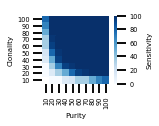

In [39]:
tmp_df = pd.DataFrame(artificial_purities_df.groupby('real_purity').Dash_Loss_Ext.mean()).reset_index()
tmp_df.columns = ['simulated_purity', 'Dash_Accuracy']

sns.set_context('talk', font_scale=0.4)
plt.figure(figsize=(1.5, 1.25))
accuracy_matrix = []
for clonality in clonalities[::-1]:
    accuracy_array = []
    for purity in purities:
        try:
            accuracy_array.append(list(tmp_df[tmp_df.simulated_purity == 
                                              int(clonality*purity / 100)].Dash_Accuracy)[0] * 100)
        except:
            accuracy_array.append(np.nan)
    accuracy_matrix.append(accuracy_array)

sns.heatmap(accuracy_matrix, xticklabels=purities, yticklabels=clonalities[::-1], cmap="Blues",
           vmin=0, vmax=100, cbar_kws={'label': 'Sensitivity'}) #, annot=True, fmt='g')
plt.xlabel('Purity')
plt.ylabel('Clonality')
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/DASH.sensitivity.purity_clonality.heatmap.lenient.blues_r.{0}.pdf'.format(cell_line),
           bbox_inches='tight')

##### Specificity with full clonality

In [40]:
artificial_purities_raw_df = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/validation.cell_line_dash_output.{0}.csv'.format(cell_line),
                                     index_col=0)
artificial_purities_raw_df['LOH'] = True
artificial_purities_raw_df['real_purity'] = artificial_purities_raw_df['Sample'].str.split('_p').str[1].str.split('_').str[0].astype(int)
artificial_purities_raw_df['cell_line'] = artificial_purities_raw_df['Sample'].str.split('_tumor').str[0]
artificial_purities_raw_df['replicate'] = artificial_purities_raw_df['Sample'].str.split('rep').str[1]


# Only looking at purity with 100% clonality
purities = list(artificial_purities_raw_df.real_purity.unique())
no_loh_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == 0]
all_small_artificial_dfs = []
for purity in purities:
    actual_purity = purity
    if actual_purity == 1:
        continue
    tmp_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == actual_purity]
    tmp_restricted_df = pd.merge(tmp_df, no_loh_df[['Gene', 'cell_line', 'replicate']], 
                 on=['Gene', 'cell_line', 'replicate'], how='inner')
    no_loh_restricted_df = pd.merge(tmp_df[['Gene', 'cell_line', 'replicate']], no_loh_df, 
                             on=['Gene', 'cell_line', 'replicate'], how='inner')
    
    sequenza_purity = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Purity.mean()
    #print(actual_purity, sequenza_purity)
    tmp_restricted_df['adjusted_purity'] = sequenza_purity
    tmp_restricted_df['BAF'] = list(no_loh_restricted_df['BAF'])
    tmp_restricted_df['R1'] = list(no_loh_restricted_df['R1'])
    tmp_restricted_df['R2'] = list(no_loh_restricted_df['R2'])
    tmp_restricted_df['consistency_of_coverage'] = list(no_loh_restricted_df['consistency_of_coverage'])
    tmp_restricted_df['Sequenza_Loss'] = True
    all_small_artificial_dfs.append(tmp_restricted_df)

artificial_purities_df = pd.concat(all_small_artificial_dfs)
    

# Fixing purity
artificial_purities_df['old_purity'] = artificial_purities_df['Purity']
artificial_purities_df['purity'] = artificial_purities_df['adjusted_purity']


# Renaming other columns
artificial_purities_df['ploidy'] = artificial_purities_df['Ploidy']
artificial_purities_df['sequenza_minor'] = [0 if x == True else 1 for x in artificial_purities_df['Sequenza_Loss']]
artificial_purities_df['minMedCoverage'] = artificial_purities_df[['R1','R2']].min(axis=1)
artificial_purities_df['baf_median'] = artificial_purities_df['BAF']
artificial_purities_df['percCov'] = artificial_purities_df['consistency_of_coverage']
artificial_purities_df['totalCoverage_median'] = artificial_purities_df['total_coverage']
artificial_purities_df['Sequenza_Loss'] = ~artificial_purities_df['sequenza_minor'].astype(bool)

In [41]:
artificial_purities_df[training_columns]

X_test = artificial_purities_df[training_columns]
y_test = artificial_purities_df[['LOH']]

predictions = model.predict(X_test) #predict_prob [:, 1]
prediction_probs = model.predict_proba(X_test)[:, 1]

In [42]:
artificial_purities_df['Check_FP'] = (artificial_purities_df.baf_median > BAF_cutoff) \
                                         &(artificial_purities_df.minMedCoverage < R_cutoff) #\
                                         #&(artificial_purities_df.sequenza_minor == 1)

In [43]:
lenient = []
for x, check in zip(prediction_probs, artificial_purities_df['Check_FP']):
    if (x > cutoff) and (check):
        lenient.append(0)
    else:
        lenient.append(1)
artificial_purities_df['Dash_Loss_Ext'] = lenient

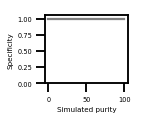

In [44]:
plt.figure(figsize=(1.5, 1.25))
sns.set_context('talk', font_scale=0.4)

sns.lineplot(x='real_purity', y='Dash_Loss_Ext', data=artificial_purities_df, color='grey')

plt.xlabel('Simulated purity')
plt.ylabel('Specificity')
plt.ylim(0, 1.05)
#plt.title('DASH')
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/DASH.specificity.purity.line.{0}.pdf'.format(cell_line), bbox_inches='tight')

In [45]:
artificial_purities_df.groupby('real_purity')['Dash_Loss_Ext'].mean()

real_purity
0      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
12     1
14     1
15     1
16     1
18     1
20     1
21     1
24     1
25     1
27     1
28     1
30     1
32     1
35     1
36     1
40     1
42     1
45     1
48     1
49     1
50     1
54     1
56     1
60     1
63     1
64     1
70     1
72     1
80     1
81     1
90     1
100    1
Name: Dash_Loss_Ext, dtype: int64

##### Specificity across variable clonalities

In [46]:
all_small_artificial_dfs = []
purities = list(range(10, 110, 10))
clonalities = list(range(10, 110, 10))
no_loh_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == 0]
for purity in purities:
    for clonality in clonalities:
        actual_purity = round(int(purity*clonality)/100)
        if actual_purity == 1:
            continue
        tmp_df = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == actual_purity]
        tmp_restricted_df = pd.merge(tmp_df, no_loh_df[['Gene', 'cell_line', 'replicate']], 
                     on=['Gene', 'cell_line', 'replicate'], how='inner')
        no_loh_restricted_df = pd.merge(tmp_df[['Gene', 'cell_line', 'replicate']], no_loh_df, 
                             on=['Gene', 'cell_line', 'replicate'], how='inner')
        
        sequenza_purity = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Purity.mean()
        tmp_restricted_df['adjusted_purity'] = sequenza_purity
        sequenza_ploidy = artificial_purities_raw_df[artificial_purities_raw_df.real_purity == purity].Ploidy.mean()
        tmp_restricted_df['adjusted_ploidy'] = sequenza_ploidy
        tmp_restricted_df['BAF'] = list(no_loh_restricted_df['BAF'])
        tmp_restricted_df['R1'] = list(no_loh_restricted_df['R1'])
        tmp_restricted_df['R2'] = list(no_loh_restricted_df['R2'])
        tmp_restricted_df['consistency_of_coverage'] = list(no_loh_restricted_df['consistency_of_coverage'])
        tmp_restricted_df['Sequenza_Loss'] = list(no_loh_restricted_df['Sequenza_Loss'])
        all_small_artificial_dfs.append(tmp_restricted_df)

artificial_purities_df = pd.concat(all_small_artificial_dfs)
    

# Fixing purity/ploidy
artificial_purities_df['old_purity'] = artificial_purities_df['Purity']
artificial_purities_df['purity'] = artificial_purities_df['adjusted_purity']
artificial_purities_df['old_ploidy'] = artificial_purities_df['Ploidy']
artificial_purities_df['ploidy'] = artificial_purities_df['adjusted_ploidy']

# Renaming other columns
artificial_purities_df['sequenza_minor'] = [0 if x == True else 1 for x in artificial_purities_df['Sequenza_Loss']]
artificial_purities_df['minMedCoverage'] = artificial_purities_df[['R1','R2']].min(axis=1)
artificial_purities_df['baf_median'] = artificial_purities_df['BAF']
artificial_purities_df['percCov'] = artificial_purities_df['consistency_of_coverage']
artificial_purities_df['totalCoverage_median'] = artificial_purities_df['total_coverage']
artificial_purities_df['Sequenza_Loss'] = ~artificial_purities_df['sequenza_minor'].astype(bool)

In [47]:
X_test = artificial_purities_df[training_columns]
y_test = artificial_purities_df[['LOH']]

predictions = model.predict(X_test) #predict_prob [:, 1]
prediction_probs = model.predict_proba(X_test)[:, 1]

In [48]:
# Adding secondary check
artificial_purities_df['Check_FP'] = (artificial_purities_df.baf_median > BAF_cutoff) \
                                         &(artificial_purities_df.minMedCoverage < R_cutoff) #\
                                         #&(artificial_purities_df.sequenza_minor == 1)

In [49]:
lenient = []
for x, check in zip(prediction_probs, artificial_purities_df['Check_FP']):
    if (x > cutoff) and (check):
        lenient.append(1)
    else:
        lenient.append(0)
artificial_purities_df['Dash_Loss_Ext'] = lenient

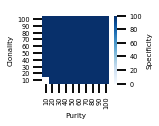

In [50]:
tmp_df = pd.DataFrame(artificial_purities_df.groupby('real_purity').Dash_Loss_Ext.mean()).reset_index()
tmp_df.columns = ['simulated_purity', 'Dash_Accuracy']
tmp_df['DASH_Specificity'] = 1 - tmp_df.Dash_Accuracy # Inverted for specificity (these are negatives)

sns.set_context('talk', font_scale=0.4)
plt.figure(figsize=(1.5, 1.25))
accuracy_matrix = []
for purity in purities[::-1]:
    accuracy_array = []
    for clonality in clonalities:
        try:
            accuracy_array.append(list(tmp_df[tmp_df.simulated_purity == 
                                              int(clonality*purity / 100)].DASH_Specificity)[0] * 100)
        except:
            accuracy_array.append(np.nan)
    accuracy_matrix.append(accuracy_array)

sns.heatmap(accuracy_matrix, xticklabels=purities, yticklabels=clonalities[::-1], cmap="Blues",
           vmin=0, vmax=100, cbar_kws={'label': 'Specificity'}) #, annot=True, fmt='g')
plt.xlabel('Purity')
plt.ylabel('Clonality')
#plt.title('Updated Algorithm')
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/DASH.specificity.purity_clonality.heatmap.lenient.blues_r.{0}.pdf'.format(cell_line),
           bbox_inches='tight')